### Домашнее задание 1 - 10 баллов

1. Загрузите датасет артефактов вредоносного ПО, хранящихся в памяти - [cybersecurity.csv](cybersequrity.csv)
2. Подготовьте данные к обучению - **1 балл**
    - Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используйте столбец `Class` - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО).
    - **hint**: для ускорения сходимости и стабилизации обучения можно стандартизировать входные признаки, например, с помощью `StandardScaler`
    - Создайте объекты для работы с данными в PyTorch - `Dataset` и `DataLoader` для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, `batch_size`.
3. Реализуйте класс бейзлайновой нейросетевой модели (MLP) для решения задачи - **2 балла**
    - Определите оптимальное количество `Linear` слоев в структуре и их размерности.
    - Подберите оптимальные для задачи функции активации - `ReLU`, `Sigmoid`, `Tanh`, `LeakyReLU`...
    - Реализуйте логику прохождения данных по сети в методе `forward`
    - Cоздайте объект модели, реализуйте перевод модели на gpu
4. Напишите код цикла обучения - train-loop и валидации - eval-loop. В процессе обучения сохраняйте и визуализируйте на графике динамику функции потерь на тренировочной и валидационной выборках - **1 балл**
5. Обучите модель и проверьте ее качество - **1 балл**
    - Выберите оптимизатор, в качестве функции потерь используйте `nn.BCELoss`
    - Запустите обучение, постарайтесь подобрать оптимальные скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val
    - Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации - `classification_report`
6. Улучшите архитектуру модели из пункта 3 и добейтесь увеличения качества - **3 балла**
    - Попробуйте добавить слои `BatchNorm1d` и `Dropout` - поэкспериментируйте с их "расположением" в сети, напишите свои выводы о целесообразности их добавления в модель, оптимальном расположении, влиянии на качество/сходимость обучения. При использовании слоя `Dropout` - определите экспериментально или обоснуйте теоретически оптимальное значение параметра `p`.
    - Обучите улучшенную модель и проверьте ее качество (при необходимости измените гиперпараметры обучения - `batch_size`, скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val и архитектуру модели)

**Общее**

- Принимаемые решения обоснованы (почему выбрана определенная архитектура/гиперпараметр/оптимизатор/проеобразование и т.п.) - **1 балл**
- Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**

**Формат сдачи ДЗ**

- Создать отедльный репозиторий (если еще не создавали)
- Выдать доступ в репозиторий своему ментору и pacifikus (распределение по менторам и их ники на гитхабе есть в [таблице](https://docs.google.com/spreadsheets/d/1qneC-kHlNzgkCzRoGA9dgUbDthyQd-FA3GhvLCMQY_M/edit?usp=sharing)
- Каждая домашняя работа – PR в отдельную ветку **hw_n**, где **n** - номер домашней работы
- Добавить ментора и pacifikus в reviewers
- Дождаться ревью, если все ок – мержим в main
- Если не ок – вносим исправления и снова отправляем на ревью

In [1]:
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm
from collections import defaultdict

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


# 1.Загрузите датасет артефактов вредоносного ПО, хранящихся в памяти - [cybersecurity.csv](cybersequrity.csv)

In [3]:
df = pd.read_csv('/content/cybersequrity.csv', sep=',')
print(df.shape)
df.head()

(10000, 16)


,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   svcscan.fs_drivers                      10000 non-null  int64  
 1   callbacks.ngeneric                      10000 non-null  int64  
 2   psxview.not_in_eprocess_pool_false_avg  10000 non-null  float64
 3   psxview.not_in_eprocess_pool            10000 non-null  int64  
 4   callbacks.nanonymous                    10000 non-null  int64  
 5   psxview.not_in_session                  10000 non-null  int64  
 6   psxview.not_in_pslist                   10000 non-null  int64  
 7   psxview.not_in_pspcid_list              10000 non-null  int64  
 8   psxview.not_in_ethread_pool             10000 non-null  int64  
 9   psxview.not_in_csrss_handles            10000 non-null  int64  
 10  psxview.not_in_pslist_false_avg         10000 non-null  flo

In [5]:
df['Class'].value_counts(dropna=False)

,count
Class,
1,5096
0,4904


# 2.Подготовьте данные к обучению - **1 балл**
    
- Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используйте столбец `Class` - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО).
- **hint**: для ускорения сходимости и стабилизации обучения можно стандартизировать входные признаки, например, с помощью `StandardScaler`
- Создайте объекты для работы с данными в PyTorch - `Dataset` и `DataLoader` для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, `batch_size`.

In [6]:
X, y = df.drop(['Class'], axis=1), df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=42,
                                                  stratify=y_train,
                                                  shuffle=True)

X_train.shape, X_val.shape, X_test.shape

((6000, 15), (2000, 15), (2000, 15))

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)

X_val = scaler.fit_transform(X_val)
X_val = pd.DataFrame(X_val)

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X.values)
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [9]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#3.Реализуйте класс бейзлайновой нейросетевой модели (MLP) для решения задачи - **2 балла**
- Определите оптимальное количество `Linear` слоев в структуре и их размерности.
- Подберите оптимальные для задачи функции активации - `ReLU`, `Sigmoid`, `Tanh`, `LeakyReLU`...
- Реализуйте логику прохождения данных по сети в методе `forward`
- Cоздайте объект модели, реализуйте перевод модели на gpu

# 4.Напишите код цикла обучения - train-loop и валидации - eval-loop.
В процессе обучения сохраняйте и визуализируйте на графике динамику функции потерь на тренировочной и валидационной выборках - 1 балл

- В качестве первого приближения возьмём 3 линейных слоя, так как всегда лучше начинать с гораздо более простой модели (например, с меньшим количеством слоёв, без дополнительных функций), и увеличивать модель в ширину или глубину до тех пор, пока ситуация не перестанет улучшаться
- Для размерности скрытых слоём возьмём также стандартно - размерность пространства признаков
- Для первого приближения в качестве функции активации возьмём ReLU. LeakyReLU пока не трогаем, чтобы не мучиться с подбором альфы. Sigmoid, Tanh не используем, чтобы не наткнуться на затухание градиента
- Также считаем f1 метрику, чтобы отслеживать динамику изменений precision и recall


In [10]:
class BestTorchModel(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [11]:
def train_model(model, num_epochs=100, eval_freq=10):
  train_loss_history, eval_loss_history = [], []
  train_f1_history, eval_f1_history = [], []
  global_step = 0

  model.train()
  for epoch in tqdm(range(num_epochs)):
      for batch_X, target in train_dataloader:
        optimizer.zero_grad()
        log_probs = model(batch_X.to(device))
        loss = loss_function(log_probs, target.to(device))
        loss.backward()
        optimizer.step()

        preds = (log_probs >= 0.5).int().cpu().tolist()
        f1 = f1_score(preds, target.cpu().numpy().tolist())

        train_loss_history.append((global_step, loss.item()))
        train_f1_history.append((global_step, f1))

        if global_step % eval_freq == 0:
              val_loss, val_f1 = evaluate(model)
              eval_loss_history.append((global_step, val_loss))
              eval_f1_history.append((global_step, val_f1))
              model.train()

        if global_step % 250 == 0:
              clear_output(True)

              plt.figure(figsize=(15, 5))

              plt.subplot(121)
              plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
              if len(eval_loss_history):
                  plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
              plt.legend()

              plt.subplot(122)
              plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
              if len(eval_f1_history):
                  plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
              plt.legend()
              plt.show()
        global_step += 1

  return model

In [12]:
@torch.no_grad()
def evaluate(model, mode='eval', print_res='no'):
    model.eval()

    dataloader = val_dataloader if mode == 'eval' else test_dataloader

    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for batch_X, target in dataloader:
      log_probs = model(batch_X.to(device))
      loss = loss_function(log_probs, target.to(device))
      num = log_probs.shape[0]
      loss_epoch += loss.item() * num
      num_epoch += num

      preds_list += (log_probs >= 0.5).int().cpu().tolist()
      targets_list += target.cpu().numpy().tolist()

    f1 = f1_score(preds_list, targets_list)

    if print_res == 'yes':
      print(classification_report(targets_list, preds_list))
      print('loss, f1:', loss_epoch / num_epoch, f1)

    return loss_epoch / num_epoch, f1

# 5.Обучите модель и проверьте ее качество - **1 балл**
- Выберите оптимизатор, в качестве функции потерь используйте `nn.BCELoss`
- Запустите обучение, постарайтесь подобрать оптимальные скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val
- Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации - `classification_report`

- В качестве оптимизатора выберем стандартный Adam. Так как он является одним из самых популярных и надёжных адаптивных оптимизаторов, объединяющий идеи Momentum и Adaptive learning rate

## Оптимизация количества эпох

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

cuda


BestTorchModel(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=1, bias=True)
  )
)

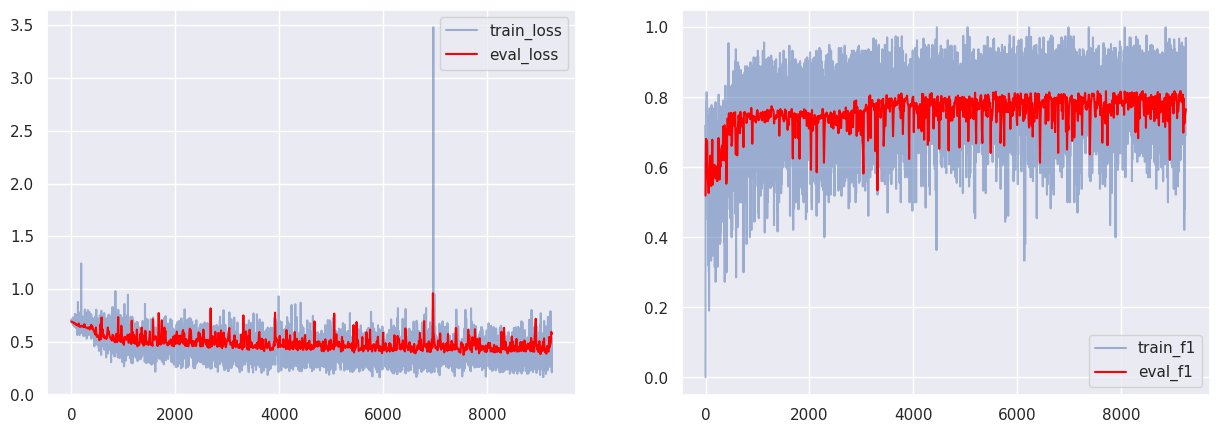

              precision    recall  f1-score   support

         0.0       0.88      0.37      0.52       981
         1.0       0.61      0.95      0.74      1019

    accuracy                           0.67      2000
   macro avg       0.74      0.66      0.63      2000
weighted avg       0.74      0.67      0.63      2000

loss, f1: 0.8445296993255615 0.7434715821812596


(0.8445296993255615, 0.7434715821812596)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=50)
evaluate(model, mode='test', print_res='yes')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

cuda


BestTorchModel(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=1, bias=True)
  )
)

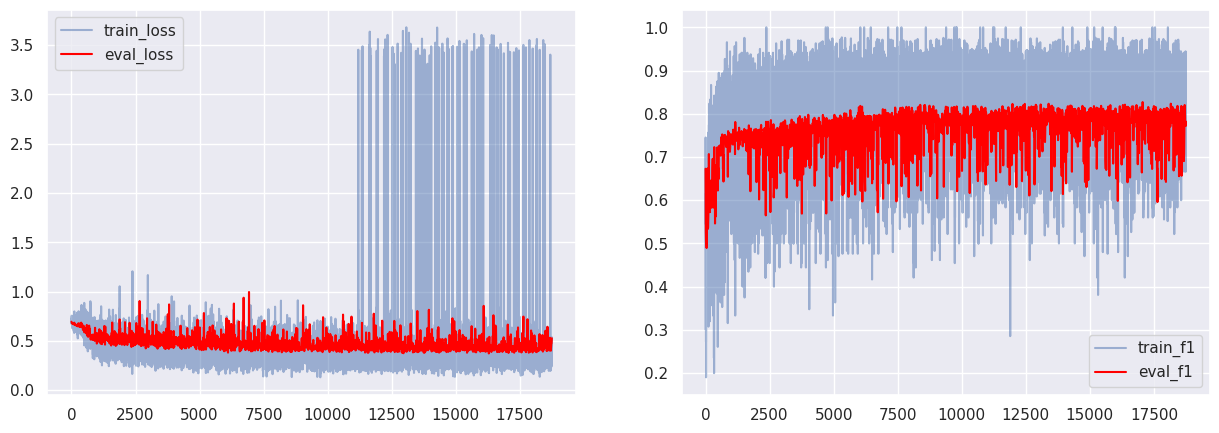

              precision    recall  f1-score   support

         0.0       0.58      0.45      0.51       981
         1.0       0.57      0.68      0.62      1019

    accuracy                           0.57      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.57      0.57      0.57      2000

loss, f1: 1.0890140099525452 0.6198934280639432


(1.0890140099525452, 0.6198934280639432)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=100)
evaluate(model, mode='test', print_res='yes')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

cuda


BestTorchModel(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=1, bias=True)
  )
)

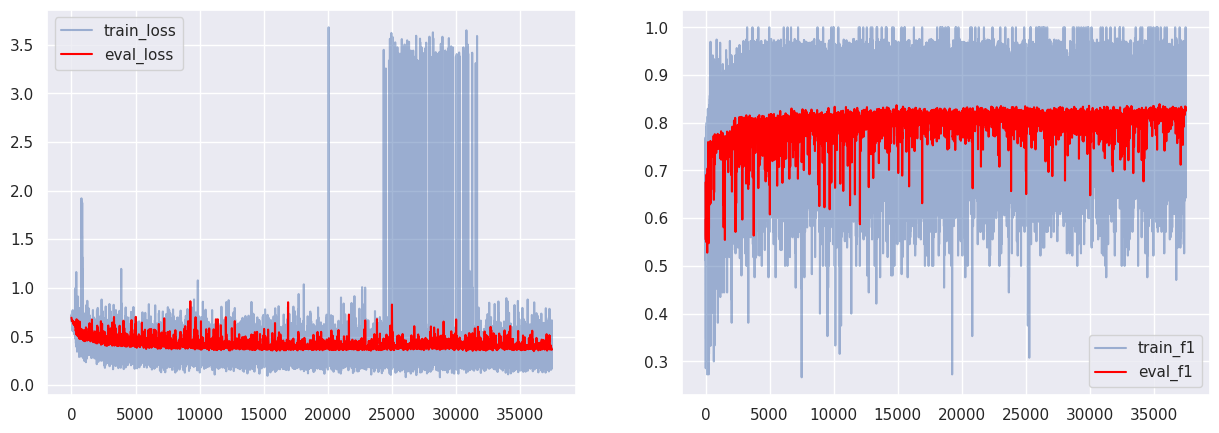

              precision    recall  f1-score   support

         0.0       0.84      0.44      0.58       981
         1.0       0.63      0.92      0.75      1019

    accuracy                           0.68      2000
   macro avg       0.74      0.68      0.66      2000
weighted avg       0.73      0.68      0.66      2000

loss, f1: 0.8572070689201355 0.74780526735834


(0.8572070689201355, 0.74780526735834)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=200)
evaluate(model, mode='test', print_res='yes')

- 50 эпох:
  - test loss, f1: 0.8445296993255615 0.7434715821812596
- 100 эпох:
  - test loss, f1: 1.0890140099525452 0.6198934280639432
- 200 эпох:
  - test loss, f1: 0.8572070689201355 0.74780526735834

  
  Вывод:
  Предварительно выберем 200 эпох, так как, 1) судя по графику потерь и метрики, на 50 эпохах модель ещё не совсем стабильна, хотя показывает хороший результат, 2) в конце 100 эпох loss на трэйне начинает слишком сильно скакать, 3) значение потерь и метрики на тестовой выборке самое высокое при 200 эпохах

## Оптимизация lr

In [ ]:
test_loss, test_f1 = [], []

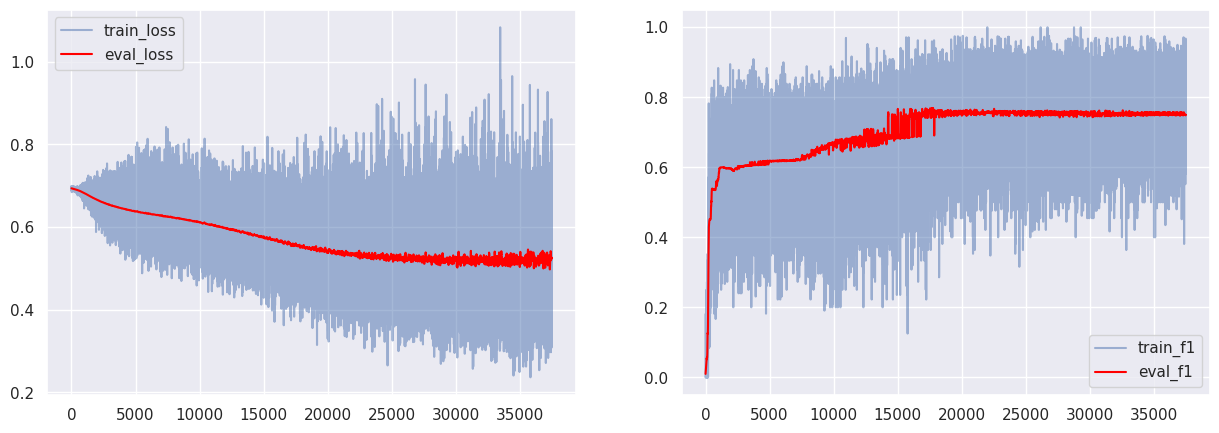

              precision    recall  f1-score   support

         0.0       0.94      0.27      0.42       981
         1.0       0.58      0.98      0.73      1019

    accuracy                           0.63      2000
   macro avg       0.76      0.63      0.58      2000
weighted avg       0.76      0.63      0.58      2000

loss, f1: 0.714856367111206 0.7327239488117002


In [ ]:
lr = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model = train_model(model, num_epochs=200)
loss, f1 = evaluate(model, mode='test', print_res='yes')

test_loss.append(loss)
test_f1.append(f1)

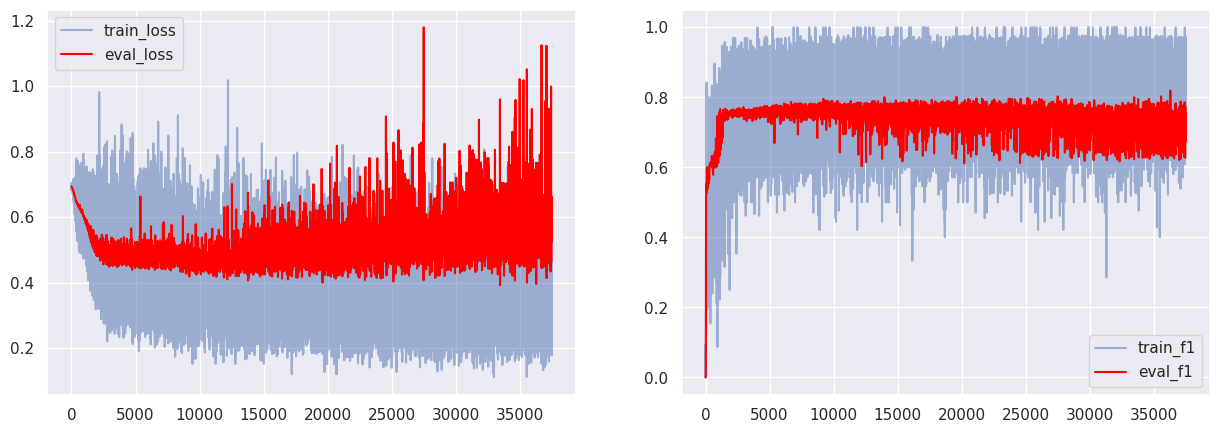

              precision    recall  f1-score   support

         0.0       0.59      0.41      0.48       981
         1.0       0.56      0.72      0.63      1019

    accuracy                           0.57      2000
   macro avg       0.57      0.56      0.55      2000
weighted avg       0.57      0.57      0.56      2000

loss, f1: 1.3670701379776 0.629867351305092


In [ ]:
lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model = train_model(model, num_epochs=200)
loss, f1 = evaluate(model, mode='test', print_res='yes')

test_loss.append(loss)
test_f1.append(f1)

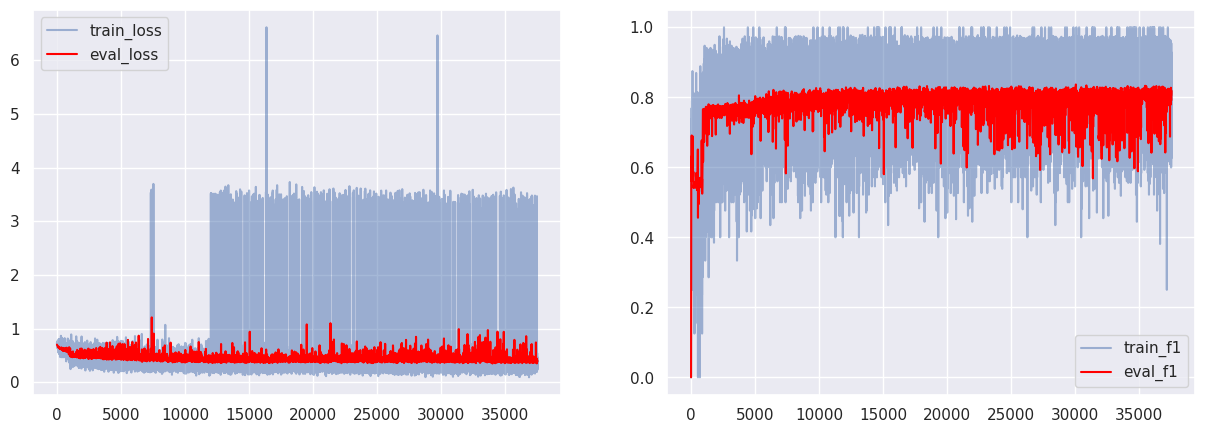

              precision    recall  f1-score   support

         0.0       0.74      0.71      0.72       981
         1.0       0.73      0.76      0.74      1019

    accuracy                           0.73      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.74      0.73      0.73      2000

loss, f1: 0.6909761395454407 0.7449470644850819


In [ ]:
lr = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model = train_model(model, num_epochs=200)
loss, f1 = evaluate(model, mode='test', print_res='yes')

test_loss.append(loss)
test_f1.append(f1)

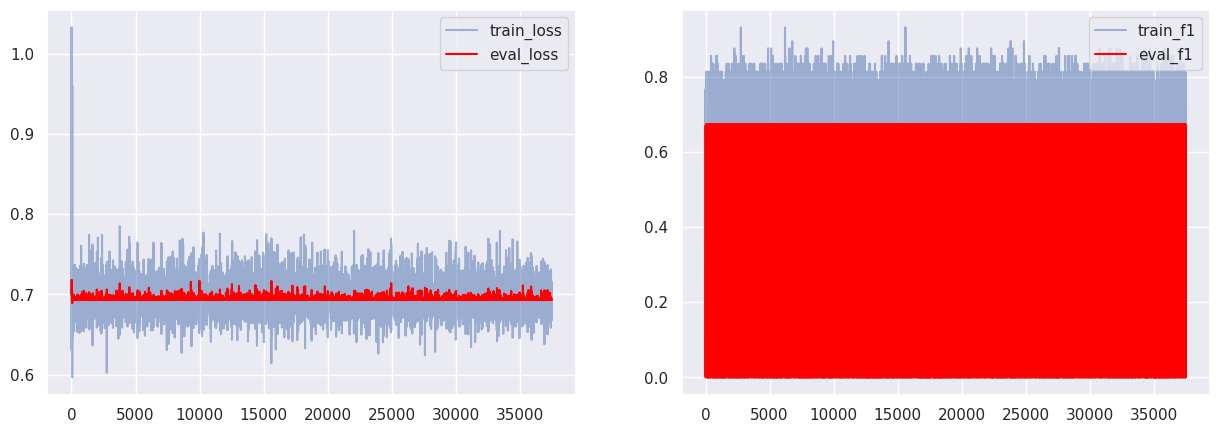

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       981
         1.0       0.00      0.00      0.00      1019

    accuracy                           0.49      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.24      0.49      0.32      2000

loss, f1: 0.6940940732955933 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
lr = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model = train_model(model, num_epochs=200)
loss, f1 = evaluate(model, mode='test', print_res='yes')

test_loss.append(loss)
test_f1.append(f1)

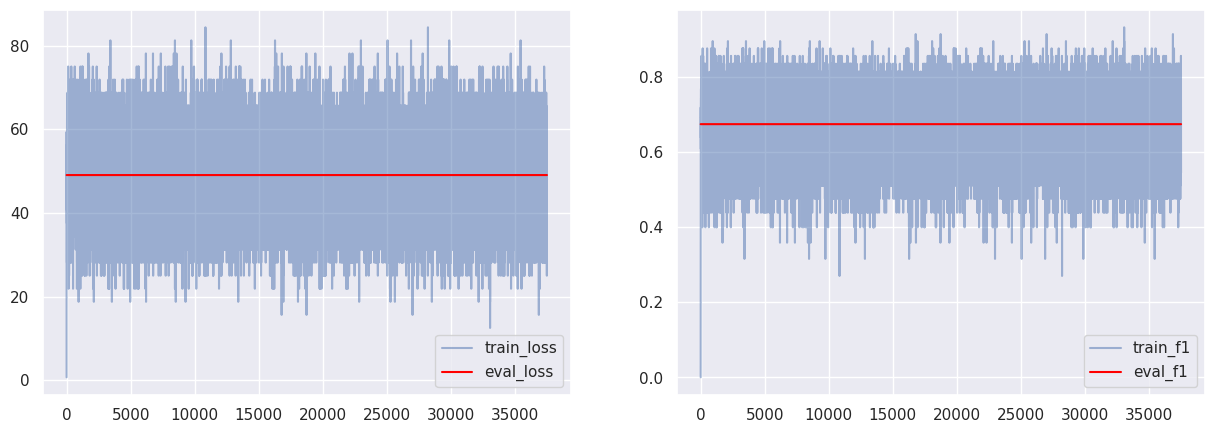

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       981
         1.0       0.51      1.00      0.68      1019

    accuracy                           0.51      2000
   macro avg       0.25      0.50      0.34      2000
weighted avg       0.26      0.51      0.34      2000

loss, f1: 49.05 0.6750579662139782


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
lr = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model = train_model(model, num_epochs=200)
loss, f1 = evaluate(model, mode='test', print_res='yes')

test_loss.append(loss)
test_f1.append(f1)

In [ ]:
print('test_loss =', test_loss)
print('test_f1 =', test_f1)

test_loss = [0.714856367111206, 1.3670701379776, 0.6909761395454407, 0.6940940732955933, 49.05]
test_f1 = [0.7327239488117002, 0.629867351305092, 0.7449470644850819, 0.0, 0.6750579662139782]


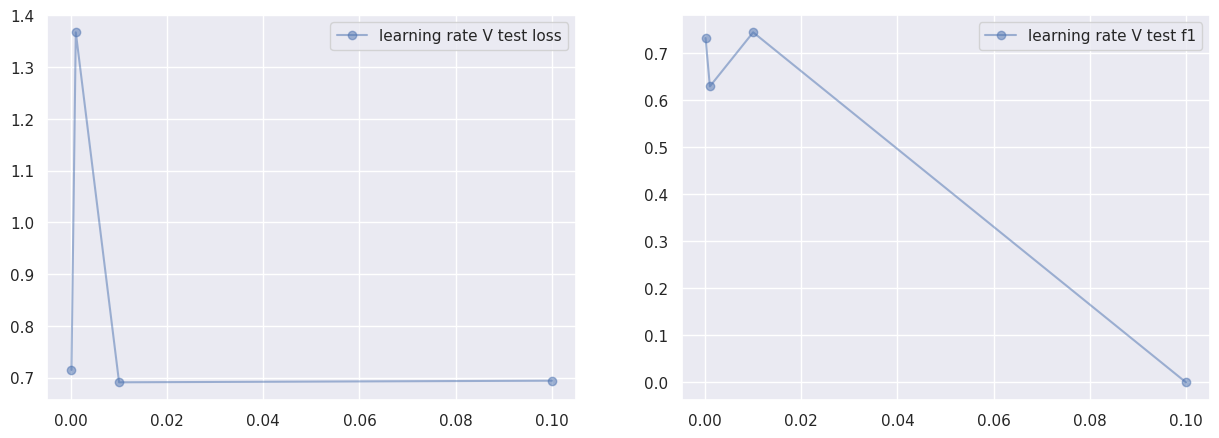

In [ ]:
# отрисовываем лосс и метрику без learning_rate = 10, чтобы график был читаемым, к тому же при данном значении лосс слишком высокий

lrs = [0.0001, 0.001, 0.01, 0.1, 10]
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(lrs[:-1], test_loss[:-1], alpha=0.5, label='learning rate V test loss', marker='o')
plt.legend()

plt.subplot(122)
plt.plot(lrs[:-1], test_f1[:-1], alpha=0.5, label='learning rate V test f1', marker='o')
plt.legend()
plt.show()

Вывод: в результате такого простого эксперимента получается, что learning rate = 0.01 является оптимальным. При lr меньше либо больше 0.01, модель либо сходится очень медленно, либо перестаёт обучаться

Итог: на данном этапе лучшая модель получилась при num_epochs = 200, lr = 0.01

# 6.Улучшите архитектуру модели из пункта 3 и добейтесь увеличения качества - **3 балла**
- Попробуйте добавить слои `BatchNorm1d` и `Dropout` - поэкспериментируйте с их "расположением" в сети, напишите свои выводы о целесообразности их добавления в модель, оптимальном расположении, влиянии на качество/сходимость обучения. При использовании слоя `Dropout` - определите экспериментально или обоснуйте теоретически оптимальное значение параметра `p`.
- Обучите улучшенную модель и проверьте ее качество (при необходимости измените гиперпараметры обучения - `batch_size`, скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val и архитектуру модели)


## BatchNorm1d -> ReLU

In [ ]:
class BestTorchModel_BN(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel_BN(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

cuda


BestTorchModel_BN(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=15, out_features=15, bias=True)
    (4): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=15, bias=True)
    (7): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=15, out_features=1, bias=True)
  )
)

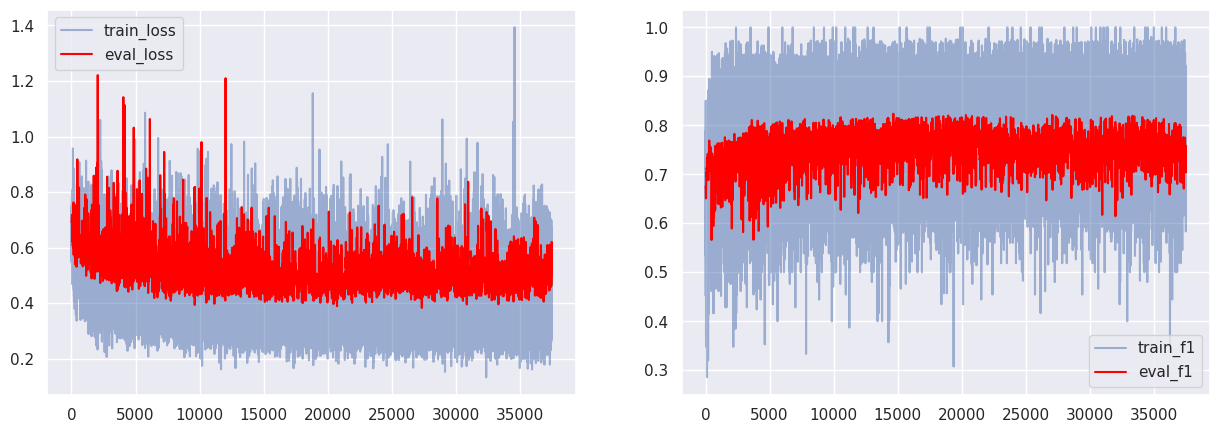

              precision    recall  f1-score   support

         0.0       0.70      0.35      0.47       981
         1.0       0.58      0.85      0.69      1019

    accuracy                           0.61      2000
   macro avg       0.64      0.60      0.58      2000
weighted avg       0.64      0.61      0.58      2000

loss, f1: 0.6387557020187378 0.6896551724137931


(0.6387557020187378, 0.6896551724137931)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=200)
evaluate(model, mode='test', print_res='yes')

Хотя идейно BatchNorm должен уменьшать зашумлённость, в данном случае этого не произошло. Под конец обучения кажется что метрики даже стали ухудшаться. Поробуем взять чуть меньше эпох

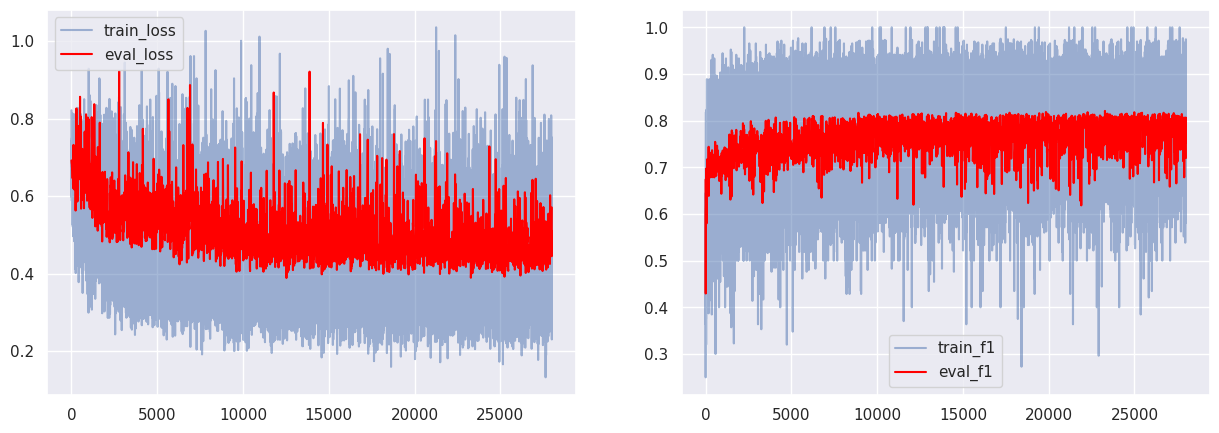

              precision    recall  f1-score   support

         0.0       0.84      0.36      0.51       981
         1.0       0.60      0.93      0.73      1019

    accuracy                           0.65      2000
   macro avg       0.72      0.65      0.62      2000
weighted avg       0.72      0.65      0.62      2000

loss, f1: 0.5542857098579407 0.7319706903200925


(0.5542857098579407, 0.7319706903200925)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel_BN(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=150)
evaluate(model, mode='test', print_res='yes')

Стало лучше, видимо в какой-то момент модель начинала переобучаться. Попробуем 100 эпох

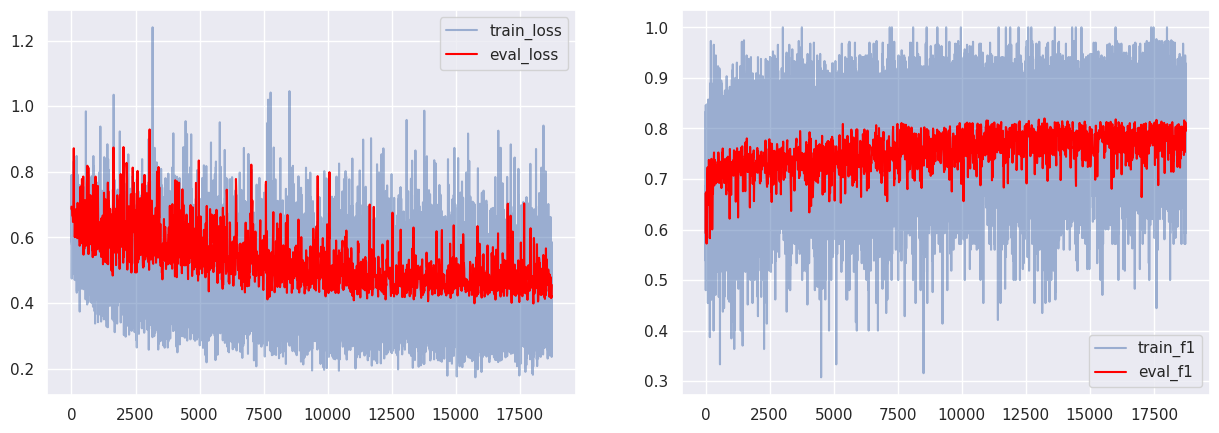

              precision    recall  f1-score   support

         0.0       0.82      0.36      0.51       981
         1.0       0.60      0.92      0.73      1019

    accuracy                           0.65      2000
   macro avg       0.71      0.64      0.62      2000
weighted avg       0.71      0.65      0.62      2000

loss, f1: 0.5834653737545014 0.7291021671826625


(0.5834653737545014, 0.7291021671826625)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel_BN(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=100)
evaluate(model, mode='test', print_res='yes')

Кажется, что на 100 эпохах мы всё так недообучаемся

## ReLU -> BatchNorm1d

In [ ]:
class BestTorchModel_BN(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), activation(), nn.BatchNorm1d(hidden_size)]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation())
            layers.append(nn.BatchNorm1d(hidden_size))

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel_BN(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

cuda


BestTorchModel_BN(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=15, out_features=15, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=15, out_features=15, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=15, out_features=1, bias=True)
  )
)

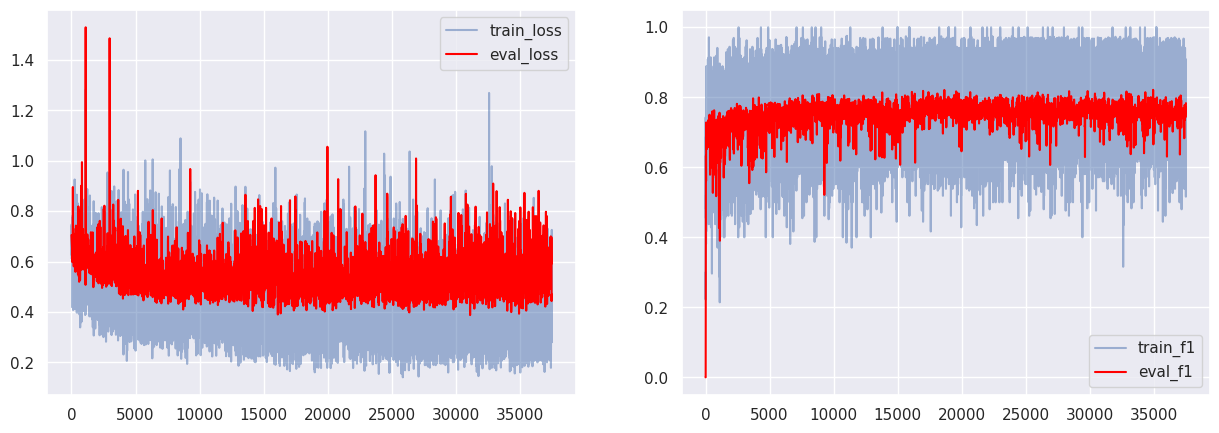

              precision    recall  f1-score   support

         0.0       0.53      0.37      0.44       981
         1.0       0.53      0.68      0.60      1019

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.52      2000
weighted avg       0.53      0.53      0.52      2000

loss, f1: 1.893924361228943 0.5962199312714777


(1.893924361228943, 0.5962199312714777)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=200)
evaluate(model, mode='test', print_res='yes')

Эти результаты выглядят похуже чем BatchNorm1d -> ReLU

Вывод:

- Лучшая модель без BatchNorm1d:
  - test loss, f1: 0.8572070689201355, 0.74780526735834
- Модель со структурой: BatchNorm1d -> ReLU
  - test loss, f1 (200 epoch): 0.6387557020187378, 0.6896551724137931
  - test loss, f1 (150 epoch): 0.5542857098579407, 0.7319706903200925
  - test loss, f1 (100 epoch): 0.5834653737545014, 0.7291021671826625
- Модель со структурой: ReLU -> BatchNorm1d
  - test loss, f1 (200 epoch): 1.893924361228943, 0.5962199312714777
  - test loss, f1 (150 epoch): 0.9888420038223267, 0.6514333194848358

## BatchNorm1d -> Dropout -> ReLU

In [ ]:
class BestTorchModel_BN_Dropout(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN_Dropout, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(p=0.1))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel_BN_Dropout(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

cuda


BestTorchModel_BN_Dropout(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=15, out_features=15, bias=True)
    (4): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=15, out_features=15, bias=True)
    (8): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=15, out_features=1, bias=True)
  )
)

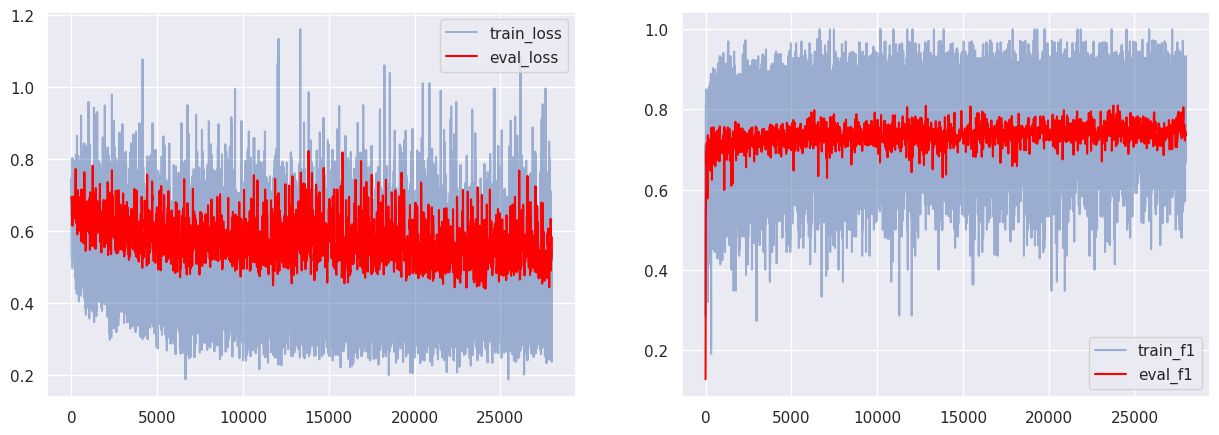

              precision    recall  f1-score   support

         0.0       0.89      0.32      0.47       981
         1.0       0.60      0.96      0.74      1019

    accuracy                           0.65      2000
   macro avg       0.74      0.64      0.61      2000
weighted avg       0.74      0.65      0.61      2000

loss, f1: 0.6423934857845306 0.7360120165227187


(0.6423934857845306, 0.7360120165227187)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=150)
evaluate(model, mode='test', print_res='yes')

Есть незначительные хорошие изменения в сторону метрики f1, но loss при этом увеличился - что плохо. Попробуем использовать большую вероятность.

In [ ]:
class BestTorchModel_BN_Dropout(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN_Dropout, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(p=0.3))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

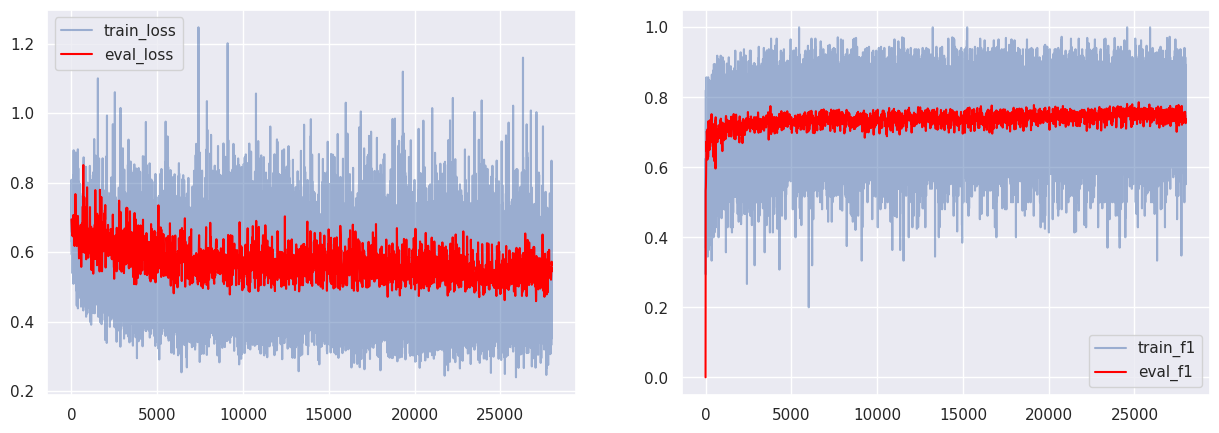

              precision    recall  f1-score   support

         0.0       0.92      0.32      0.48       981
         1.0       0.60      0.97      0.74      1019

    accuracy                           0.65      2000
   macro avg       0.76      0.65      0.61      2000
weighted avg       0.76      0.65      0.61      2000

loss, f1: 0.6539988007545471 0.7414050822122571


(0.6539988007545471, 0.7414050822122571)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel_BN_Dropout(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=150)
evaluate(model, mode='test', print_res='yes')

Стало чуть лучше, попробуем дожать ещё немного

In [13]:
class BestTorchModel_BN_Dropout(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN_Dropout, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(p=0.5))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

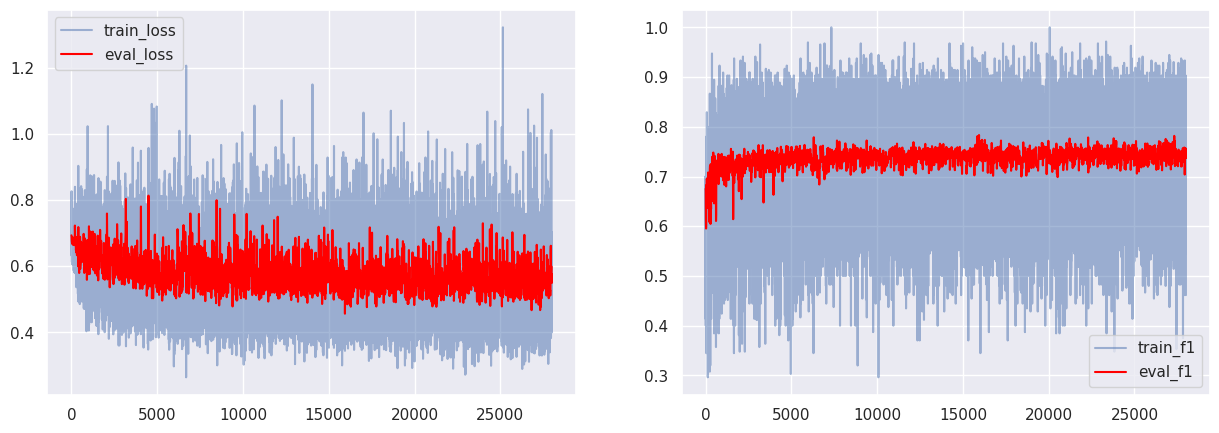

              precision    recall  f1-score   support

         0.0       0.89      0.31      0.46       981
         1.0       0.59      0.96      0.73      1019

    accuracy                           0.65      2000
   macro avg       0.74      0.64      0.60      2000
weighted avg       0.74      0.65      0.60      2000

loss, f1: 0.7533653106689453 0.7344801795063575


(0.7533653106689453, 0.7344801795063575)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel_BN_Dropout(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=150)
evaluate(model, mode='test', print_res='yes')

Dropout p = 0.6, лучшая модель:

In [15]:
class BestTorchModel_BN_Dropout(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN_Dropout, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(p=0.6))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

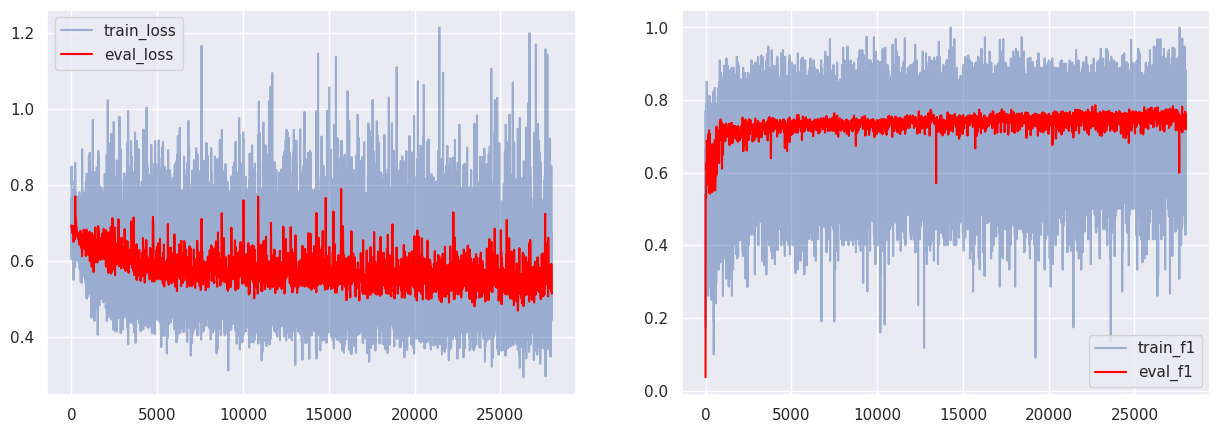

              precision    recall  f1-score   support

         0.0       0.82      0.50      0.62       981
         1.0       0.65      0.89      0.75      1019

    accuracy                           0.70      2000
   macro avg       0.73      0.70      0.68      2000
weighted avg       0.73      0.70      0.69      2000

loss, f1: 0.6214488124847413 0.7516501650165016


(0.6214488124847413, 0.7516501650165016)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BestTorchModel_BN_Dropout(num_labels = 1, input_size = 15, hidden_size = 15, n_linear_layers = 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=150)
evaluate(model, mode='test', print_res='yes')

При довольно высоком Dropout получили модель лучшего качества, видимо текущая модель всё ещё склонна к переобучению, и её можно пробовать дотюнивать менее радикальными методами

-----------------------------------------

Результаты:

- Модель без BatchNorm1d и Dropout:
  - test loss, f1: 0.8572070689201355, 0.74780526735834
- Модель со структурой: BatchNorm1d -> ReLU
  - test loss, f1 (200 epoch): 0.6387557020187378, 0.6896551724137931
  - test loss, f1 (150 epoch): 0.5542857098579407, 0.7319706903200925
  - test loss, f1 (100 epoch): 0.5834653737545014, 0.7291021671826625
- Модель со структурой: **BatchNorm1d -> Dropout -> ReLU**
  - test loss, f1 (150 epoch, p=0.1): 0.6423934857845306, 0.7360120165227187
  - test loss, f1 (150 epoch, p=0.3): 0.6539988007545471, 0.7414050822122571
  - test loss, f1 (150 epoch, p=0.4): 0.6123068146705627, 0.7410478703354693
  - test loss, f1 (150 epoch, p=0.4): 0.7533653106689453, 0.7344801795063575
  - test loss, f1 (150 epoch, **p=0.6**): 0.6214488124847413, 0.7516501650165016

Итог: **добились небольшого улучшения качества модели**
- было: модель (num_epochs=200, lr=0.0) ReLU без BatchNorm1d и Dropout, test loss, f1: **0.857, 0.748**
- стало: модель (num_epochs=150, lr=0.01),  с архитектурой BatchNorm1d -> Dropout (p=0.6) -> ReLU, test loss, f1: **0.621, 0.752**